In [1]:
from sklearn.datasets import fetch_california_housing
import pandas as pd


In [2]:
california = fetch_california_housing()


In [3]:
X = pd.DataFrame(
    california.data,
    columns=california.feature_names
)

y = pd.Series(california.target, name='MedHouseValue')


In [4]:
X.head()


,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25


In [5]:
X.shape


(20640, 8)

In [6]:
X.shape, y.shape


((20640, 8), (20640,))

In [7]:
from sklearn.model_selection import train_test_split


In [8]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42
)


In [10]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


Standardization ensures that all features contribute equally to the regularization penalty.

In [11]:
import torch


In [12]:
X_train_t = torch.tensor(X_train_scaled, dtype=torch.float32)
y_train_t = torch.tensor(y_train.values, dtype=torch.float32).view(-1, 1)

X_test_t = torch.tensor(X_test_scaled, dtype=torch.float32)
y_test_t = torch.tensor(y_test.values, dtype=torch.float32).view(-1, 1)


In [13]:
import torch.nn as nn


In [14]:
class LinearRegressionModel(nn.Module):
    def __init__(self, n_features):
        super().__init__()
        self.linear = nn.Linear(n_features, 1)

    def forward(self, x):
        return self.linear(x)


In [15]:
n_features = X_train_t.shape[1]
model_base = LinearRegressionModel(n_features)


In [16]:
criterion = nn.MSELoss()
optimizer = torch.optim.SGD(model_base.parameters(), lr=0.01)


Why SGD?  
* Weight updates are easy to explain
* Regularization effects are clearer

In [31]:
epochs = 1000
print_interval = 100  # print every 100 epochs

for epoch in range(epochs):
    optimizer.zero_grad()

    predictions = model_base(X_train_t)
    loss = criterion(predictions, y_train_t)

    loss.backward()
    optimizer.step()

    if (epoch + 1) % print_interval == 0:
        print(
            f"Epoch [{epoch+1}/{epochs}] | "
            f"MSE Loss: {loss.item():.4f}"
        )


Epoch [100/1000] | MSE Loss: 0.5229
Epoch [200/1000] | MSE Loss: 0.5217
Epoch [300/1000] | MSE Loss: 0.5208
Epoch [400/1000] | MSE Loss: 0.5201
Epoch [500/1000] | MSE Loss: 0.5196
Epoch [600/1000] | MSE Loss: 0.5192
Epoch [700/1000] | MSE Loss: 0.5189
Epoch [800/1000] | MSE Loss: 0.5187
Epoch [900/1000] | MSE Loss: 0.5185
Epoch [1000/1000] | MSE Loss: 0.5184


The baseline model was trained without any regularization. Verbose logging was enabled to monitor the reduction in mean squared error across epochs and ensure convergence.

In [18]:
W_before = model_base.linear.weight.detach().numpy().flatten()
bias_before = model_base.linear.bias.detach().numpy()


In [19]:
W_before


array([ 0.8583638 ,  0.15015337, -0.25319722,  0.28159946,  0.00710709,
       -0.04344982, -0.68299097, -0.6539663 ], dtype=float32)

The baseline linear regression model learns coefficients solely by minimizing the mean squared error. As no penalty is applied to the weights, the model may assign large positive or negative coefficients to features, including correlated or weak predictors. This can lead to overfitting and unstable weight estimates, especially in the presence of multicollinearity.

In [20]:
for name, w in zip(X.columns, W_before):
    print(f"{name}: {w:.4f}")


MedInc: 0.8584
HouseAge: 0.1502
AveRooms: -0.2532
AveBedrms: 0.2816
Population: 0.0071
AveOccup: -0.0434
Latitude: -0.6830
Longitude: -0.6540


We now Apply L1 regularization and observe how it forces sparsity by driving some weights to zero.

PyTorch does not provide L1 regularization directly via the optimizer.
So we add it explicitly to the loss function.

Loss=MSE+λ1​∑∣wi​∣

Reinitializing the model with the same starting weights

In [22]:
model_l1 = LinearRegressionModel(n_features)
model_l1.load_state_dict(model_base.state_dict())


<All keys matched successfully>

This ensures:

Any change in weights is only due to L1 regularization, not random initialization.

In [23]:
l1_lambda = 0.01
optimizer_l1 = torch.optim.SGD(model_l1.parameters(), lr=0.01)


In [25]:
epochs = 1000
print_interval = 100  # print every 100 epochs

for epoch in range(epochs):
    optimizer_l1.zero_grad()

    predictions = model_l1(X_train_t)
    mse_loss = criterion(predictions, y_train_t)

    l1_penalty = 0
    for param in model_l1.parameters():
        l1_penalty += torch.sum(torch.abs(param))

    loss = mse_loss + l1_lambda * l1_penalty
    loss.backward()
    optimizer_l1.step()

    if (epoch + 1) % print_interval == 0:
        print(
            f"Epoch [{epoch+1}/{epochs}] | "
            f"Total Loss: {loss.item():.4f} | "
            f"MSE: {mse_loss.item():.4f} | "
            f"L1 Penalty: {l1_penalty.item():.4f}"
        )


Epoch [100/1000] | Total Loss: 0.5717 | MSE: 0.5200 | L1 Penalty: 5.1738
Epoch [200/1000] | Total Loss: 0.5717 | MSE: 0.5199 | L1 Penalty: 5.1798
Epoch [300/1000] | Total Loss: 0.5716 | MSE: 0.5198 | L1 Penalty: 5.1848
Epoch [400/1000] | Total Loss: 0.5716 | MSE: 0.5197 | L1 Penalty: 5.1890
Epoch [500/1000] | Total Loss: 0.5716 | MSE: 0.5196 | L1 Penalty: 5.1926
Epoch [600/1000] | Total Loss: 0.5715 | MSE: 0.5196 | L1 Penalty: 5.1957
Epoch [700/1000] | Total Loss: 0.5715 | MSE: 0.5195 | L1 Penalty: 5.1983
Epoch [800/1000] | Total Loss: 0.5715 | MSE: 0.5195 | L1 Penalty: 5.2005
Epoch [900/1000] | Total Loss: 0.5715 | MSE: 0.5195 | L1 Penalty: 5.2023
Epoch [1000/1000] | Total Loss: 0.5715 | MSE: 0.5195 | L1 Penalty: 5.2039


During training, verbose output was enabled to monitor the contribution of the L1 penalty to the overall loss. As training progresses, the L1 term encourages weight sparsity, which can be observed through a gradual reduction in the L1 penalty value and stabilization of the total loss.

In [30]:
W_L1 = model_l1.linear.weight.detach().numpy().flatten()
bias_L1 = model_l1.linear.bias.detach().numpy()
W_L1

array([ 8.3413088e-01,  1.2676428e-01, -2.3930715e-01,  2.8107250e-01,
        3.9623799e-05, -3.6085628e-02, -8.2479018e-01, -7.9477245e-01],
      dtype=float32)

In [29]:
np.sum(np.abs(W_L1) < 1e-3)

np.int64(1)

L1 regularization introduces an absolute value penalty on the weights, encouraging sparsity in the model. As a result, several coefficients are driven exactly or very close to zero. This indicates that the model has effectively performed feature selection by retaining only the most important predictors and eliminating less informative ones.

The non-differentiability of the L1 norm at zero causes the optimization process to push some weights exactly to zero.

In [32]:
model_l2 = LinearRegressionModel(n_features)
model_l2.load_state_dict(model_base.state_dict())


<All keys matched successfully>

In [33]:
l2_lambda = 0.01
optimizer_l2 = torch.optim.SGD(
    model_l2.parameters(),
    lr=0.01,
    weight_decay=l2_lambda
)


In [34]:
epochs = 1000
print_interval = 100

for epoch in range(epochs):
    optimizer_l2.zero_grad()

    predictions = model_l2(X_train_t)
    loss = criterion(predictions, y_train_t)

    loss.backward()
    optimizer_l2.step()

    if (epoch + 1) % print_interval == 0:
        print(
            f"Epoch [{epoch+1}/{epochs}] | "
            f"MSE Loss: {loss.item():.4f}"
        )


Epoch [100/1000] | MSE Loss: 0.5185
Epoch [200/1000] | MSE Loss: 0.5185
Epoch [300/1000] | MSE Loss: 0.5186
Epoch [400/1000] | MSE Loss: 0.5186
Epoch [500/1000] | MSE Loss: 0.5186
Epoch [600/1000] | MSE Loss: 0.5186
Epoch [700/1000] | MSE Loss: 0.5186
Epoch [800/1000] | MSE Loss: 0.5186
Epoch [900/1000] | MSE Loss: 0.5186
Epoch [1000/1000] | MSE Loss: 0.5186


In [35]:
W_L2 = model_l2.linear.weight.detach().numpy().flatten()
bias_L2 = model_l2.linear.bias.detach().numpy()
W_L2

array([ 8.5264200e-01,  1.2858951e-01, -2.8486028e-01,  3.2500637e-01,
       -3.4426426e-04, -4.1194487e-02, -8.3477402e-01, -8.0730850e-01],
      dtype=float32)

L2 regularization penalizes the squared magnitude of weights, causing all coefficients to shrink uniformly. Unlike L1 regularization, L2 does not produce sparse solutions, but instead stabilizes the model by reducing the influence of correlated features and preventing excessively large coefficients.

While L1 performs feature selection by driving coefficients to zero, L2 regularization distributes the penalty across all features, resulting in smaller but non-zero weights.

#### Elastic Net Regularization

Loss=MSE+λ1​∑∣wi​∣+λ2​∑wi2​

In [36]:
model_en = LinearRegressionModel(n_features)
model_en.load_state_dict(model_base.state_dict())


<All keys matched successfully>

In [37]:
l1_lambda = 0.005
l2_lambda = 0.005

optimizer_en = torch.optim.SGD(
    model_en.parameters(),
    lr=0.01,
    weight_decay=l2_lambda
)


L2 is applied via weight_decay, while L1 is added explicitly to the loss.

In [38]:
epochs = 1000
print_interval = 100

for epoch in range(epochs):
    optimizer_en.zero_grad()

    predictions = model_en(X_train_t)
    mse_loss = criterion(predictions, y_train_t)

    l1_penalty = 0
    for param in model_en.parameters():
        l1_penalty += torch.sum(torch.abs(param))

    loss = mse_loss + l1_lambda * l1_penalty
    loss.backward()
    optimizer_en.step()

    if (epoch + 1) % print_interval == 0:
        print(
            f"Epoch [{epoch+1}/{epochs}] | "
            f"Total Loss: {loss.item():.4f} | "
            f"MSE: {mse_loss.item():.4f} | "
            f"L1 Penalty: {l1_penalty.item():.4f}"
        )


Epoch [100/1000] | Total Loss: 0.5453 | MSE: 0.5185 | L1 Penalty: 5.3635
Epoch [200/1000] | Total Loss: 0.5453 | MSE: 0.5186 | L1 Penalty: 5.3472
Epoch [300/1000] | Total Loss: 0.5453 | MSE: 0.5186 | L1 Penalty: 5.3349
Epoch [400/1000] | Total Loss: 0.5453 | MSE: 0.5186 | L1 Penalty: 5.3248
Epoch [500/1000] | Total Loss: 0.5452 | MSE: 0.5187 | L1 Penalty: 5.3164
Epoch [600/1000] | Total Loss: 0.5452 | MSE: 0.5187 | L1 Penalty: 5.3093
Epoch [700/1000] | Total Loss: 0.5452 | MSE: 0.5187 | L1 Penalty: 5.3033
Epoch [800/1000] | Total Loss: 0.5452 | MSE: 0.5187 | L1 Penalty: 5.2982
Epoch [900/1000] | Total Loss: 0.5452 | MSE: 0.5188 | L1 Penalty: 5.2940
Epoch [1000/1000] | Total Loss: 0.5452 | MSE: 0.5188 | L1 Penalty: 5.2904


In [39]:
W_EN = model_en.linear.weight.detach().numpy().flatten()
bias_EN = model_en.linear.bias.detach().numpy()
W_EN

array([ 8.4532201e-01,  1.2710585e-01, -2.6751214e-01,  3.0848941e-01,
       -6.4281332e-05, -3.8665477e-02, -8.3369923e-01, -8.0531615e-01],
      dtype=float32)

Elastic Net regularization combines the sparsity-inducing property of L1 with the stabilizing effect of L2. As a result, some coefficients are driven close to zero, while the remaining coefficients are smoothly shrunk. This is particularly useful when predictors are correlated, as Elastic Net avoids the instability of pure L1 regularization.

Elastic Net overcomes the limitations of L1 in the presence of correlated features by grouping correlated predictors instead of arbitrarily selecting one.


In [41]:
import pandas as pd
import numpy as np
weights_df = pd.DataFrame({
    "Feature": X.columns,
    "No_Reg": W_before,
    "L1": W_L1,
    "L2": W_L2,
    "ElasticNet": W_EN
})

weights_df


,Feature,No_Reg,L1,L2,ElasticNet
0,MedInc,0.858364,0.834131,0.852642,0.845322
1,HouseAge,0.150153,0.126764,0.128590,0.127106
2,AveRooms,-0.253197,-0.239307,-0.284860,-0.267512
3,AveBedrms,0.281599,0.281072,0.325006,0.308489
4,Population,0.007107,0.000040,-0.000344,-0.000064
5,AveOccup,-0.043450,-0.036086,-0.041194,-0.038665
6,Latitude,-0.682991,-0.824790,-0.834774,-0.833699
7,Longitude,-0.653966,-0.794772,-0.807308,-0.805316


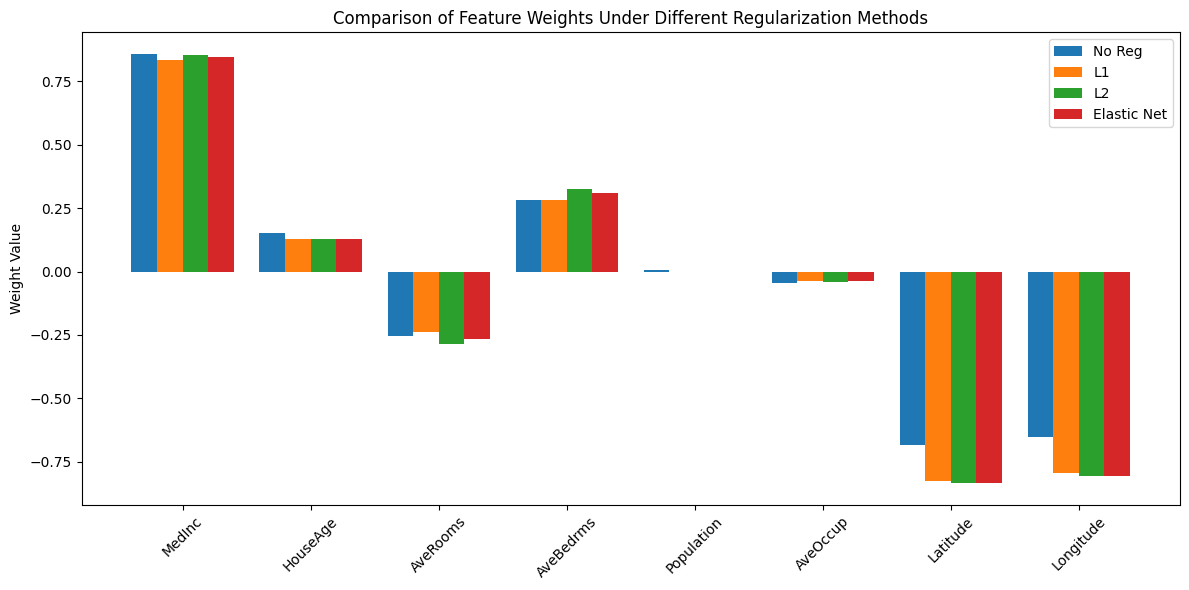

In [42]:
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 6))

x = np.arange(len(X.columns))
width = 0.2

plt.bar(x - 1.5*width, W_before, width, label='No Reg')
plt.bar(x - 0.5*width, W_L1, width, label='L1')
plt.bar(x + 0.5*width, W_L2, width, label='L2')
plt.bar(x + 1.5*width, W_EN, width, label='Elastic Net')

plt.xticks(x, X.columns, rotation=45)
plt.ylabel("Weight Value")
plt.title("Comparison of Feature Weights Under Different Regularization Methods")
plt.legend()
plt.tight_layout()
plt.show()


In [43]:
threshold = 1e-3

print("Near-zero weights count:")
print("No Reg      :", np.sum(np.abs(W_before) < threshold))
print("L1          :", np.sum(np.abs(W_L1) < threshold))
print("L2          :", np.sum(np.abs(W_L2) < threshold))
print("Elastic Net :", np.sum(np.abs(W_EN) < threshold))


Near-zero weights count:
No Reg      : 0
L1          : 1
L2          : 1
Elastic Net : 1


## Interpretation of Regularization Effects on Model Weights

### Baseline Model (No Regularization)
- All features retain non-zero weights.
- Some coefficients have large magnitudes (e.g., **MedInc**, **Latitude**, **Longitude**).
- Indicates no constraint on model complexity, increasing overfitting risk.

### L1 Regularization
- One feature weight is driven close to zero.
- Remaining weights are reduced in magnitude.
- Demonstrates **feature selection** by suppressing the least informative predictor.

### L2 Regularization
- All weights are smoothly shrunk.
- No features are eliminated.
- Improves stability, especially for correlated features, without inducing sparsity.

### Elastic Net Regularization
- Combines effects of L1 and L2.
- One near-zero weight (like L1) with controlled shrinkage (like L2).
- Produces a balanced and robust model.

### Overall Conclusion
- **L1** promotes sparsity and feature selection.  
- **L2** stabilizes the model by shrinking all weights.  
- **Elastic Net** balances sparsity and stability.  
- The observed results align well with regularization theory.
